In [23]:
import Data.dataset as ds
import Plots.plots as pl
import Calculations.monte_carlo as mc
import Calculations.calculations as cal
import Calculations.probability as pb
from fitter import Fitter, get_common_distributions, get_distributions


import numpy as np 
import statsmodels.api as sm 
import pylab as py

In [24]:
zone1 = ds.get_out1()
zone2 = ds.get_out2()

mass = ('Mass', 'Mass [kg]')
velocity = ('Velocity', 'Velocity [m/s]')
kinetic_energy = ('Kinetic Energy', 'Kinetic Energy [kJ]')
timedelta = ('Timedelta', 'TimeDiffHours')
n_years = 10000

In [25]:
without_outliers_zone1 = ds.replace_outliers_with_median(zone1)
without_outliers_zone2 = ds.replace_outliers_with_median(zone2)

Zone1 Timedelta


,TimeDiffHours
0,0.0
1,48.0
2,63.0
3,43.0
4,44.0
...,...
2909800,12.0
2909801,4.0
2909802,54.0
2909803,3.0


Zone2 Timedelta


,TimeDiffHours
0,0.0
1,33.0
2,34.0
3,19.0
4,26.0
...,...
1901091,31.0
1901092,57.0
1901093,47.0
1901094,31.0


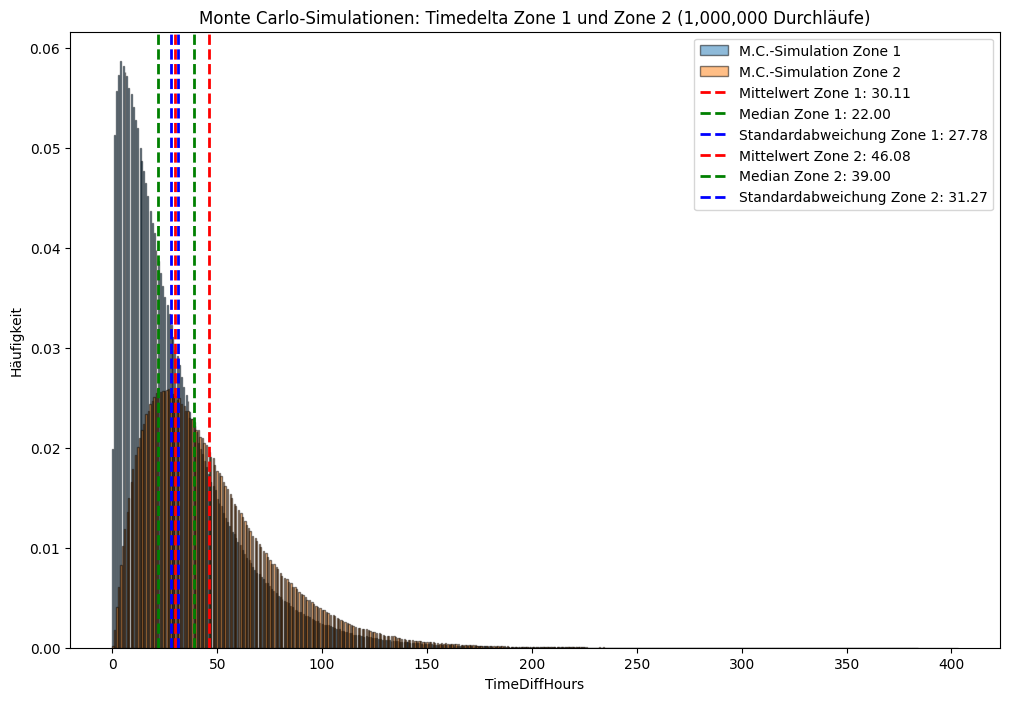

In [26]:
print('Zone1 Timedelta')
sim_timediff_zone1 = mc.simulate_gamma_distribution_timediff(without_outliers_zone1, n_years, timedelta)
display(sim_timediff_zone1)

print('Zone2 Timedelta')
sim_timediff_zone2 = mc.simulate_gamma_distribution_timediff(without_outliers_zone2, n_years, timedelta)
display(sim_timediff_zone2)

pl.show_simulated_data(sim_timediff_zone1, sim_timediff_zone2, timedelta)

n_simulations_zone1 = len(sim_timediff_zone1)
n_simulations_zone2 = len(sim_timediff_zone2)

Zone1 Velocity


,Velocity [m/s]
0,9.543021
1,8.997487
2,9.705969
3,10.705411
4,8.815222
...,...
2909800,8.425281
2909801,8.514382
2909802,10.076142
2909803,7.399647


Zone2 Velocity


,Velocity [m/s]
0,44.647073
1,50.083058
2,34.855018
3,42.682414
4,39.736076
...,...
1901091,37.101746
1901092,42.939526
1901093,37.805400
1901094,34.924410


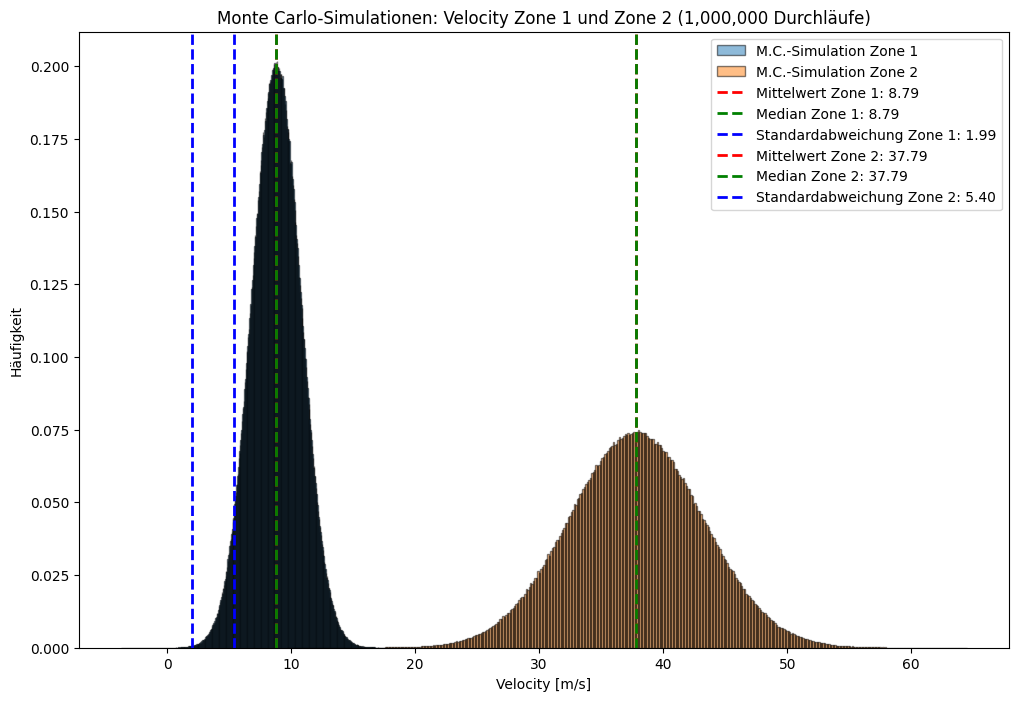

In [27]:
print('Zone1 Velocity')
sim_velocity_zone1 = mc.simulate_norm_distribution(without_outliers_zone1, n_simulations_zone1, velocity)
display(sim_velocity_zone1)

print('Zone2 Velocity')
sim_velocity_zone2 = mc.simulate_norm_distribution(without_outliers_zone2, n_simulations_zone2, velocity)
display(sim_velocity_zone2)

pl.show_simulated_data(sim_velocity_zone1, sim_velocity_zone2, velocity)

Zone1 Mass


,Mass [kg]
0,718.037587
1,160.965575
2,1082.697445
3,247.864689
4,42.769156
...,...
2909800,189.217348
2909801,733.809130
2909802,312.422413
2909803,669.215938


Zone2 Mass


,Mass [kg]
0,60.076262
1,80.491405
2,38.882936
3,23.355544
4,210.516496
...,...
1901091,39.614019
1901092,61.593309
1901093,38.518937
1901094,78.260163


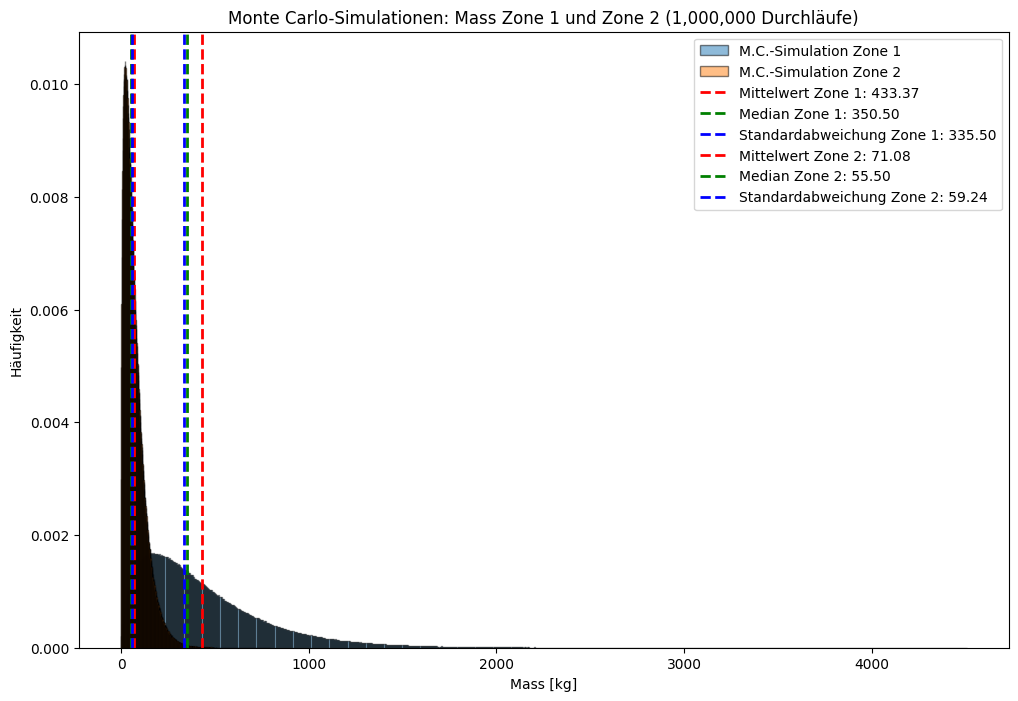

In [28]:
print('Zone1 Mass')
sim_mass_zone1 = mc.simulate_gamma_distribution(without_outliers_zone1, n_simulations_zone1, mass)
display(sim_mass_zone1)

print('Zone2 Mass')
sim_mass_zone2 = mc.simulate_gamma_distribution(without_outliers_zone2, n_simulations_zone2, mass)
display(sim_mass_zone2)

pl.show_simulated_data(sim_mass_zone1, sim_mass_zone2, mass)

In [29]:
merged_zone1 = ds.merge_simulated_data(sim_mass_zone1, sim_velocity_zone1, sim_timediff_zone1)
merged_zone2 = ds.merge_simulated_data(sim_mass_zone2, sim_velocity_zone2, sim_timediff_zone2)

print('Zone1')
display(merged_zone1)
print('Zone2')
display(merged_zone2)

Zone1


,DateTime,Year,Month,Day,Timestamp,Mass [kg],Velocity [m/s],Kinetic Energy [kJ],TimeDiffHours
0,0001-01-01 00:00:00,1,1,1,00:00,718.037587,9.543021,32.695570,0.0
1,0001-01-03 00:00:00,1,1,3,00:00,160.965575,8.997487,6.515466,48.0
2,0001-01-05 15:00:00,1,1,5,15:00,1082.697445,9.705969,50.998207,63.0
3,0001-01-07 10:00:00,1,1,7,10:00,247.864689,10.705411,14.203368,43.0
4,0001-01-09 06:00:00,1,1,9,06:00,42.769156,8.815222,1.661756,44.0
...,...,...,...,...,...,...,...,...,...
2909800,9994-05-08 05:00:00,9994,5,8,05:00,189.217348,8.425281,6.715831,12.0
2909801,9994-05-08 09:00:00,9994,5,8,09:00,733.809130,8.514382,26.598637,4.0
2909802,9994-05-10 15:00:00,9994,5,10,15:00,312.422413,10.076142,15.859910,54.0
2909803,9994-05-10 18:00:00,9994,5,10,18:00,669.215938,7.399647,18.321383,3.0


Zone2


,DateTime,Year,Month,Day,Timestamp,Mass [kg],Velocity [m/s],Kinetic Energy [kJ],TimeDiffHours
0,0001-01-01 00:00:00,1,1,1,00:00,60.076262,44.647073,59.876842,0.0
1,0001-01-02 09:00:00,1,1,2,09:00,80.491405,50.083058,100.948805,33.0
2,0001-01-03 19:00:00,1,1,3,19:00,38.882936,34.855018,23.618900,34.0
3,0001-01-04 14:00:00,1,1,4,14:00,23.355544,42.682414,21.274430,19.0
4,0001-01-05 16:00:00,1,1,5,16:00,210.516496,39.736076,166.198111,26.0
...,...,...,...,...,...,...,...,...,...
1901091,9994-04-30 12:00:00,9994,4,30,12:00,39.614019,37.101746,27.265131,31.0
1901092,9994-05-02 21:00:00,9994,5,2,21:00,61.593309,42.939526,56.782960,57.0
1901093,9994-05-04 20:00:00,9994,5,4,20:00,38.518937,37.805400,27.526561,47.0
1901094,9994-05-06 03:00:00,9994,5,6,03:00,78.260163,34.924410,47.727525,31.0


In [30]:
sim_rocks_in_net = cal.sim_calculate_cumulative_mass_since_clearing(merged_zone1, merged_zone2)
display(sim_rocks_in_net)

,DateTime,Zone,Mass [kg],Velocity [m/s],Kinetic Energy [kJ],CumulativeMassInNet
0,1-01-01 00:00,1,718.037587,9.543021,32.695570,0.000000
0,1-01-01 00:00,2,60.076262,44.647073,59.876842,0.000000
1,1-01-02 09:00,2,80.491405,50.083058,100.948805,0.000000
1,1-01-03 00:00,1,160.965575,8.997487,6.515466,80.491405
2,1-01-03 19:00,2,38.882936,34.855018,23.618900,0.000000
...,...,...,...,...,...,...
2909801,9994-05-08 09:00,1,733.809130,8.514382,26.598637,189.217348
2909802,9994-05-10 15:00,1,312.422413,10.076142,15.859910,0.000000
2909803,9994-05-10 18:00,1,669.215938,7.399647,18.321383,312.422413
2909804,9994-05-11 17:00,1,1195.964663,4.704654,13.235603,0.000000


In [31]:
net_brake_probability = pb.calculate_probability(sim_rocks_in_net)
print(net_brake_probability*100, '% Netzbruchwahrscheinlichkeit in 10000 Jahren')

80
0.0016628901737948878 % Netzbruchwahrscheinlichkeit in 10000 Jahren


In [32]:
net_brake_probability_per_year = pb.calculate_yearly_probability(net_brake_probability, n_years)
print(net_brake_probability_per_year*100, '% Netzbruchwahrscheinlichkeit pro Jahr')

1.6629040366922254e-07 % Netzbruchwahrscheinlichkeit pro Jahr


In [33]:
overall_death_probability = pb.calculate_overall_death_probability(net_brake_probability_per_year)
print(overall_death_probability*100, '% Gesamttodeswahrscheinlichkeit pro Jahr')

1.2654034557613159e-06 % Gesamttodeswahrscheinlichkeit pro Jahr
